C:\Users\kelvi\AppData\Local\Temp\ipykernel_14760\1453770830.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price_pivot.fillna(method='ffill', inplace=True)


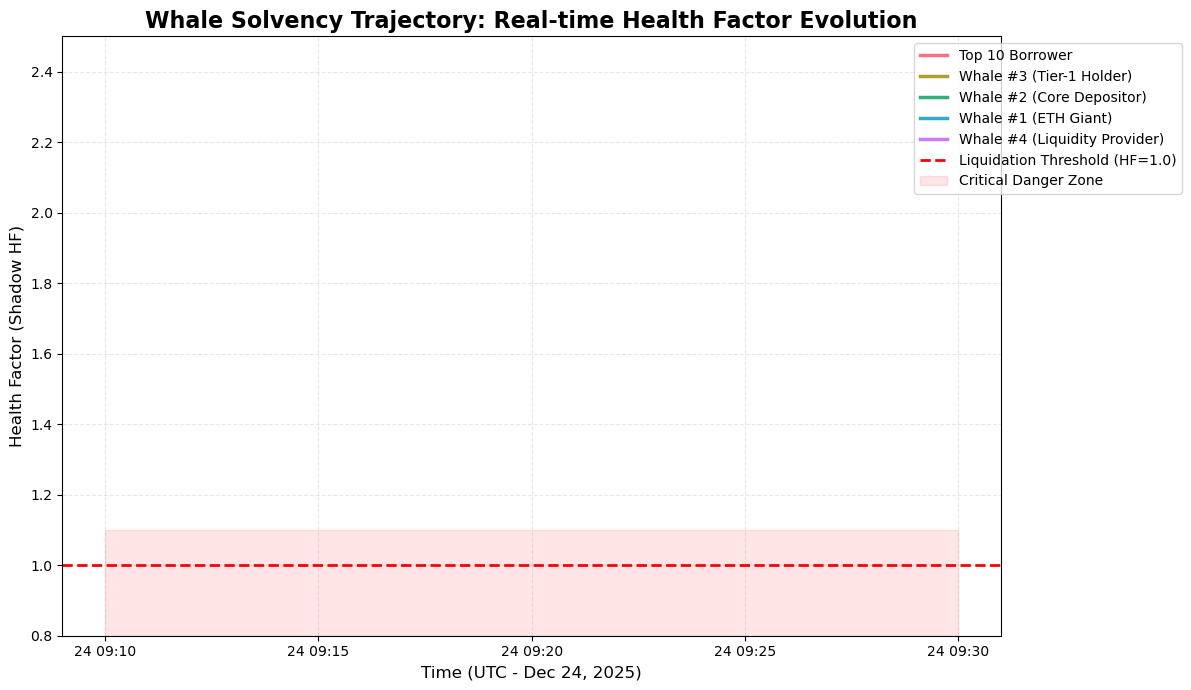

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Datasets ---
# df_whales: Snapshot of collateral and debt for top borrowers
# df_prices: 1-minute granularity benchmark prices for WETH, WBTC, etc.
df_whales = pd.read_csv('06_final_whale_solvency_parameters.csv')
df_prices = pd.read_csv('09_oracle_market_benchmarking.csv')

# --- 2. Data Alignment & Pre-processing ---
df_prices['minute'] = pd.to_datetime(df_prices['minute'], dayfirst=True)

# Pivot price data so each asset has its own column for time-series calculation
df_price_pivot = df_prices.pivot(index='minute', columns='symbol', values='price').sort_index()
# Fill missing prices (e.g., USDC stability)
if 'USDC' not in df_price_pivot: df_price_pivot['USDC'] = 1.0
df_price_pivot.fillna(method='ffill', inplace=True)

# --- 3. Health Factor (HF) Trajectory Simulation ---
# Actuarial Formula: HF = Σ (Collateral_i * Price_i * LT_i) / Total_Debt
def get_whale_hf_over_time(whale_name, whale_data, price_series):
    trajectory = []
    # Total debt is constant for this snapshot (USDT-based)
    total_debt = whale_data['current_debt_usdt'].iloc[0]
    
    for timestamp, prices in price_series.iterrows():
        total_collateral_value_weighted = 0
        for _, pos in whale_data.iterrows():
            asset = pos['asset_name']
            amount = pos['collateral_amount']
            lt = pos['liquidation_threshold']
            
            # Map assets to available price feeds
            # Note: LSTs (weETH/wstETH) are correlated to ETH price
            p = 1.0
            if asset in prices:
                p = prices[asset]
            elif asset in ['weETH', 'wstETH', 'WETH']:
                p = prices.get('WETH', 1.0)
            elif asset == 'WBTC':
                p = prices.get('WBTC', 1.0)
                
            total_collateral_value_weighted += (amount * p * lt)
        
        # Calculate HF for this specific minute
        hf = total_collateral_value_weighted / total_debt if total_debt > 0 else 5.0
        trajectory.append({'time': timestamp, 'hf': hf})
    
    return pd.DataFrame(trajectory)

# --- 4. Execution & Visualization ---
plt.figure(figsize=(12, 7))

# Analyze the Top 5 most active whales
target_whales = df_whales['whale_nickname'].unique()[:5]
colors = sns.color_palette("husl", len(target_whales))

for i, whale in enumerate(target_whales):
    whale_inventory = df_whales[df_whales['whale_nickname'] == whale]
    df_hf = get_whale_hf_over_time(whale, whale_inventory, df_price_pivot)
    
    plt.plot(df_hf['time'], df_hf['hf'], label=f'{whale}', color=colors[i], linewidth=2.5)

# --- 5. Risk Zone Annotations ---
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Liquidation Threshold (HF=1.0)')
plt.fill_between(df_price_pivot.index, 0.8, 1.1, color='red', alpha=0.1, label='Critical Danger Zone')

# Formatting for Audit Report
plt.title('Whale Solvency Trajectory: Real-time Health Factor Evolution', fontsize=16, fontweight='bold')
plt.xlabel('Time (UTC - Dec 24, 2025)', fontsize=12)
plt.ylabel('Health Factor (Shadow HF)', fontsize=12)
plt.ylim(0.8, 2.5) # Zoom into the solvency-sensitive area
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.savefig('whale_solvency_trajectory.png')
plt.show()